In [89]:
!pip install yfinance 
!pip install PyPortfolioOpt

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import sklearn.model_selection
import itertools
import statsmodels.api as sm
import warnings

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

In [91]:
import pandas as pd
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [92]:
df = df[df["Date added"] <= "2010"]
print(df.shape)

(289, 8)


In [93]:
df2 = df.groupby('GICS Sector', as_index=False).nth([0,1,2,3,4])
df2

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
6,ADM,ADM,Consumer Staples,Agricultural Products,"Chicago, Illinois",1957-03-04,7084,1902
7,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
8,ADP,ADP,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949
10,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
11,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
12,A,Agilent Technologies,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872,1999
13,APD,Air Products and Chemicals,Materials,Industrial Gases,"Allentown, Pennsylvania",1985-04-30,2969,1940
14,AKAM,Akamai,Information Technology,Internet Services & Infrastructure,"Cambridge, Massachusetts",2007-07-12,1086222,1998


In [94]:
import yfinance as yf
import numpy as np

np.array(df2['Symbol'])

array(['MMM', 'ABT', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'APD',
       'AKAM', 'ALL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG',
       'AMT', 'AMP', 'ABC', 'AMGN', 'APH', 'ADI', 'APA', 'T', 'AZO',
       'AVB', 'AVY', 'BALL', 'BBWI', 'BAX', 'BBY', 'BA', 'BKNG', 'BXP',
       'BF.B', 'CHRW', 'CPB', 'CAT', 'CBRE', 'CNP', 'CF', 'CVX', 'CTAS',
       'CLX', 'CMS', 'CMCSA', 'COP', 'CTRA', 'DVN', 'DIS', 'EMN', 'EA',
       'EQR'], dtype=object)

In [95]:
l = list(df2['Symbol'])
l.remove("BF.B")
data = yf.download(l, start="2010-01-01", end="2019-12-31", interval="1d")

[*********************100%***********************]  54 of 54 completed


In [96]:
data = data['Adj Close']

In [97]:
data = data.pct_change()
data = data.dropna()
data = np.log(1+data)
data = data.dropna()

In [56]:
data

,A,ABC,ABT,ADBE,ADI,ADM,ADP,AEE,AEP,AES,...,CVX,DIS,DVN,EA,EMN,EQR,GOOG,MMM,MO,T
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.010922,-0.007160,-0.008112,0.016313,-0.001580,0.005387,-0.005385,-0.003970,-0.011514,-0.010294,...,0.007058,-0.002498,0.001044,0.027711,-0.012876,-0.003900,-0.004413,-0.006283,0.000505,-0.004911
2010-01-06,-0.003559,-0.009500,0.005538,-0.002124,-0.001899,-0.002531,-0.002350,-0.006896,0.010082,-0.010401,...,0.000126,-0.005328,-0.003005,-0.026060,-0.006749,0.005695,-0.025532,0.014083,0.014540,-0.009873
2010-01-07,-0.001297,-0.016166,0.008250,-0.019595,-0.007953,-0.010511,-0.000471,-0.009513,0.008562,0.000747,...,-0.003775,0.000314,-0.005906,-0.007731,0.002474,0.009519,-0.023555,0.000716,-0.001495,-0.011291
2010-01-08,-0.000324,0.010807,0.005099,-0.005436,0.005732,-0.012567,-0.001413,-0.007010,0.011864,0.027964,...,0.001763,0.001570,0.001972,0.019759,0.002633,-0.012811,0.013243,0.007022,0.002490,-0.007353
2010-01-11,0.000649,0.011071,0.005074,-0.013169,-0.005732,0.000649,0.004469,0.008112,0.010337,0.006510,...,0.017587,-0.016445,-0.013757,-0.007090,0.000492,-0.003003,-0.001513,-0.004041,0.007431,-0.004808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000469,-0.002105,-0.000802,0.002095,0.004605,0.001303,-0.000647,0.001453,0.000959,-0.003032,...,0.000083,0.004207,0.011749,0.007026,0.001266,0.008370,-0.003922,-0.010080,-0.008516,-0.002819
2019-12-26,0.001757,-0.004341,0.000000,0.004721,0.000083,0.002601,0.002586,-0.001453,0.000426,0.008567,...,0.002158,0.002818,-0.006805,-0.000368,-0.002027,0.002609,0.012456,-0.000509,0.002384,0.005120
2019-12-27,-0.000351,-0.001648,0.001374,-0.001239,-0.002341,0.002162,0.002462,0.008688,0.003297,0.002505,...,-0.002491,0.000343,-0.024190,-0.000738,-0.006616,0.004457,-0.006275,0.003787,0.000000,0.002041


In [98]:
#data
logreturns = np.cumsum(data, axis=0)
logreturns.shape

(2515, 54)

In [99]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [ ]:
#rf_regressor = RandomForestRegressor(n_estimators = 500, oob_score = True, min_samples_leaf = 10).fit(X_train, y_train)
#y_pred = rf_regressor.predict(X_test)

In [100]:
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
 
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [101]:
n_steps = 60

dicti = {}

for c in data.columns:
  X_temp, y_temp = split_sequence(list(data[c]), n_steps)
  m, n = X_temp.shape

  train_len = 0
  dev_len = int(4*m/9) + train_len
  test_len = int(m/9) + dev_len
  X_train = X_temp[:dev_len]
  X_dev = X_temp[dev_len: test_len]
  X_test = X_temp[test_len: ]

  y_train = y_temp[:dev_len]
  y_dev = y_temp[dev_len: test_len]
  y_test = y_temp[test_len: ]

  dicti[c] = (X_train, y_train, X_dev, y_dev, X_test, y_test)
  #print(c)

#X_test, y_test = split_sequence(list(test_data[test_data.columns[1]]), n_steps)

In [102]:
X_train_combined = []
X_dev_combined = []
X_test_combined = []

y_train_combined = []
y_dev_combined = []
y_test_combined = []

for c in data.columns:
  x1, y1, x2, y2, x3, y3 = dicti[c]
  X_train_combined.append(x1)
  y_train_combined.append(y1)

  X_dev_combined.append(x2)
  y_dev_combined.append(y2)

  X_test_combined.append(x3)
  y_test_combined.append(y3)

X_train_combined = np.array(X_train_combined)
X_dev_combined = np.array(X_dev_combined)
X_test_combined = np.array(X_test_combined)

y_train_combined = np.array(y_train_combined)
y_dev_combined = np.array(y_dev_combined)
y_test_combined = np.array(y_test_combined)


In [103]:
X_tr = (X_train_combined.transpose(2,0,1).reshape(60,-1)).transpose()
X_tst = (X_test_combined.transpose(2,0,1).reshape(60,-1)).transpose()
X_dv = (X_dev_combined.transpose(2,0,1).reshape(60,-1)).transpose()



In [104]:
y_tr = y_train_combined.reshape(-1)
y_tst =  y_test_combined.reshape(-1)
y_dv =  y_dev_combined.reshape(-1)

In [105]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)

X_tmp = np.concatenate([X_tr,X_dv], axis = 0)
y_tmp = np.concatenate([y_tr,y_dv], axis = 0)

In [20]:
# #rf_regressor = RandomForestRegressor(n_estimators = 20, oob_score = True, min_samples_leaf = 10).fit(X_tr, y_tr)
# rf_regressor = RandomForestRegressor(n_estimators = 20)
# gridsearch = GridSearchCV(rf_regressor, {"max_depth" : [20]} , scoring='neg_mean_absolute_error', cv = tscv)
# #gridsearch = GridSearchCV(rf_regressor, {"max_depth" : [20,10], "min_samples_split": [20,10],\
#                                          #"min_samples_leaf":[20,10] }, scoring='neg_mean_absolute_error', cv = tscv)
# modelgridsearch = gridsearch.fit(X_tmp, y_tmp)

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators = 10)
#(n_estimators = 50)
#.fit(X_tr, y_tr)
gridsearch = GridSearchCV(rf_regressor, {"max_depth" : [None, 5,10], 
                                        }, scoring='neg_mean_absolute_error', cv = tscv)
modelgridsearch = gridsearch.fit(X_tmp, y_tmp)

In [66]:
#y_pred = rf_regressor.predict(X_tst)
y_pred = modelgridsearch.predict(X_tst)
pd.DataFrame(modelgridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,74.875635,37.106558,0.075096,0.015011,None,{'max_depth': None},-0.011079,-0.012045,-0.010492,-0.010790,-0.011102,0.000583,3
1,10.264545,4.794781,0.006780,0.000158,5,{'max_depth': 5},-0.011096,-0.012021,-0.010727,-0.010083,-0.010982,0.000701,2
2,18.832587,9.038147,0.009526,0.000462,10,{'max_depth': 10},-0.010999,-0.011969,-0.010637,-0.010092,-0.010924,0.000684,1


In [37]:
y_pred.shape

(58968,)

In [106]:
from pypfopt.efficient_frontier import EfficientFrontier

In [107]:
# de-annualize yearly interest rates
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate():
    # download 3-month us treasury bills rates
    annualized = yf.download("^IRX", start="2010-01-01", end="2019-12-31")["Adj Close"]
    
    # de-annualiz
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily}) 

rates = get_risk_free_rate()/100
rates

[*********************100%***********************]  1 of 1 completed


,annualized,daily
Date,,
2010-01-04,0.00055,0.000001
2010-01-05,0.00060,0.000002
2010-01-06,0.00045,0.000001
2010-01-07,0.00045,0.000001
2010-01-08,0.00040,0.000001
...,...,...
2019-12-23,0.01520,0.000025
2019-12-24,0.01538,0.000026
2019-12-26,0.01535,0.000026


In [108]:
def returns(actual_returns, weights):
    return np.dot(actual_returns.T, weights)

In [109]:
def portfolio_optimize(predicted_returns, variances, risk_free):
    ef = EfficientFrontier(predicted_returns, variances, weight_bounds = (0,1))
    weights = ef.max_sharpe(risk_free_rate = risk_free)  
    
    tangencyweights = []
    for i in weights.values():
        tangencyweights.append(float(i))
    
    tangencyweights = np.array(tangencyweights)
    return tangencyweights

In [110]:
def wrapper(input_features, predicted_returns, actual_returns, risk_free):
    variances = np.cov(input_features)
    weights = portfolio_optimize(predicted_returns, variances, risk_free)  
    return (returns(actual_returns, weights), weights)

In [70]:
weights = np.zeros((X_test_combined.shape[1], X_test_combined.shape[0]))
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
    input_features = np.exp(X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2]))-1
    predicted_returns = np.exp(y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    actual_returns = np.exp(y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    try:
        res = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
        results[i] = res[0]
        weights[i] = res[1]
    except:
        weights[i] = weights[i-1]
        results[i] = returns(actual_returns, weights[i])

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [44]:
rf_weights = weights
rf_results = results
rf_cumulative_returns = np.cumprod(results + 1)

In [45]:
X_test_combined.shape[1]

1092

In [46]:
dates = data.index

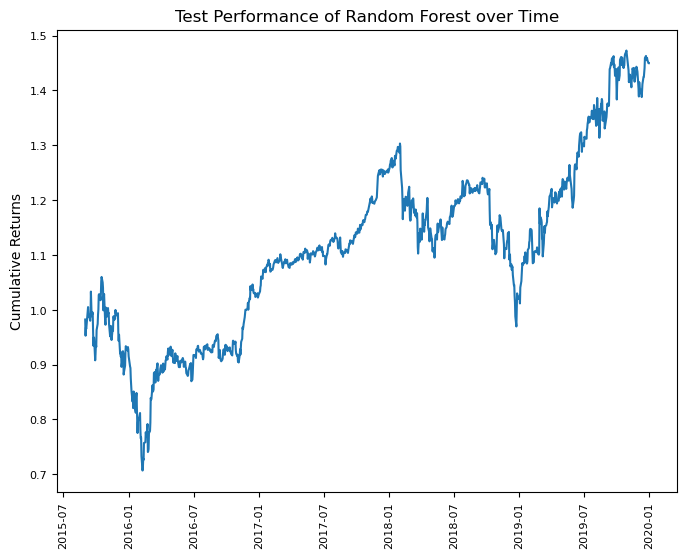

In [47]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], rf_cumulative_returns)
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Test Performance of Random Forest over Time')
plt.show()

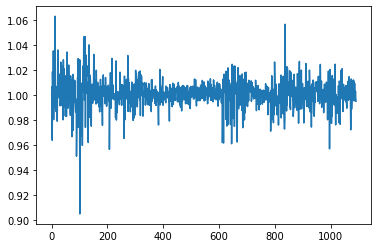

In [ ]:
plt.plot(range(X_test_combined.shape[1]), results+1)
plt.show()

In [71]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def error_metrics(y_tst, y_pred):
    errors = {}
    errors['MAE'] = mean_absolute_error(y_tst,y_pred) 
    errors['MSE'] = mean_squared_error(y_tst,y_pred) 
    errors['HR'] = np.sum(y_tst * y_pred > 0)/np.sum(y_tst * y_pred != 0)
    errors['HR+'] = np.sum(np.logical_and(y_tst > 0, y_pred > 0))/np.sum(y_pred > 0)
    errors['HR-'] = np.sum(np.logical_and(y_tst < 0, y_pred < 0))/np.sum(y_pred < 0)
    return errors

error_metrics(y_tst, y_pred)

{'MAE': 0.010801569023031971,
 'MSE': 0.0002564791315695228,
 'HR': 0.5253765497455514,
 'HR+': 0.5333820217880835,
 'HR-': 0.46232558139534885}

### SVR 

In [111]:
parameters = {'C':[1,2,4,8,16,32], 'gamma' : [1/32,1/16,1/8,1/4,1/2,1]}

model = SVR()
clf = GridSearchCV(model,parameters,scoring= 'neg_mean_absolute_error',cv = tscv)
clf.fit(X_tmp,y_tmp)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=SVR(),
             param_grid={'C': [1, 2, 4, 8, 16, 32],
                         'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1]},
             scoring='neg_mean_absolute_error')

In [112]:
clf.best_params_

{'C': 1, 'gamma': 0.03125}

In [113]:
y_pred = clf.predict(X_tst)
svr_y_pred = clf.predict(X_tst)

In [75]:
y_pred.shape

(58968,)

In [35]:
from numpy import savetxt
savetxt('svr_pred.csv', y_pred, delimiter=',')

In [114]:
y_pred = svr_y_pred

In [115]:
weights = np.zeros((X_test_combined.shape[1], X_test_combined.shape[0]))
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
    input_features = np.exp(X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2]))-1
    predicted_returns = np.exp(y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    actual_returns = np.exp(y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    try:
        res = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
        results[i] = res[0]
        weights[i] = res[1]
    except:
        weights[i] = weights[i-1]
        results[i] = returns(actual_returns, weights[i])

In [77]:
y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)[0]

array([0.00227306])

In [116]:
svr_weights = weights
svr_results = results
svr_cumulative_returns = np.cumprod(results + 1)
#svr_results = results
#svr_cumulative_returns = np.cumsum(results)
#svr_cumulative_returns = np.exp(svr_cumulative_returns)

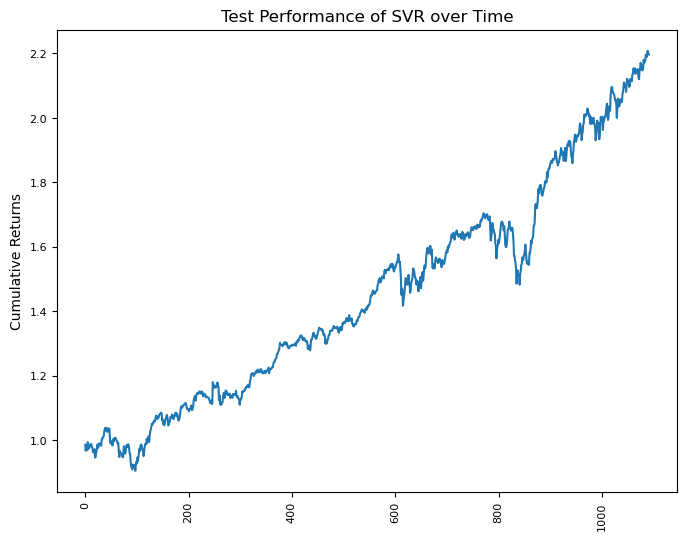

In [117]:
fig = plt.figure(figsize=(8,6))
#plt.plot(dates[-1092:], svr_cumulative_returns)
plt.plot(range(X_test_combined.shape[1]), svr_cumulative_returns)
X_test_combined.shape[1]
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Test Performance of SVR over Time')
plt.show()

In [39]:
svr_results.shape

(1092,)

In [83]:
error_metrics(y_tst, svr_y_pred)

{'MAE': 0.010789503932688896,
 'MSE': 0.0002532645484033012,
 'HR': 0.519287530070121,
 'HR+': 0.5323800060483,
 'HR-': 0.45691967808111095}

### Random Forest

In [118]:
rf_pred = pd.read_csv("rf_result.csv", delimiter=',')
rf_pred = rf_pred['0']
rf_pred = np.array(rf_pred)

In [119]:
y_pred = rf_pred

In [120]:
weights = np.zeros((X_test_combined.shape[1], X_test_combined.shape[0]))
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
    input_features = np.exp(X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2]))-1
    predicted_returns = np.exp(y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    actual_returns = np.exp(y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    try:
        res = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
        results[i] = res[0]
        weights[i] = res[1]
    except:
        weights[i] = weights[i-1]
        results[i] = returns(actual_returns, weights[i])

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [121]:
rf_weights = weights
rf_results = results
rf_cumulative_returns = np.cumprod(rf_results + 1)

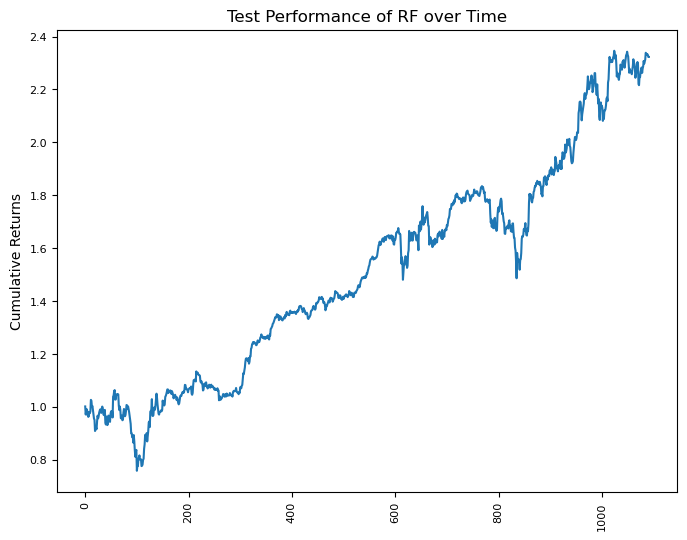

In [122]:
fig = plt.figure(figsize=(8,6))
#plt.plot(dates[-1092:], svr_cumulative_returns)
plt.plot(range(X_test_combined.shape[1]), rf_cumulative_returns)
X_test_combined.shape[1]
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Test Performance of RF over Time')
plt.show()

### CNN

In [132]:
cnn_returns = pd.read_csv("cnn_manuprig.csv", delimiter=',')
cnn_returns = cnn_returns['cnn_actual_ret']
y_pred = np.array(cnn_returns)

In [134]:
weights = np.zeros((X_test_combined.shape[1], X_test_combined.shape[0]))
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
    input_features = X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2])
    predicted_returns = y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
    actual_returns = y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1)
    try:
        res = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
        results[i] = res[0]
        weights[i] = res[1]
    except:
        weights[i] = weights[i-1]
        results[i] = returns(actual_returns, weights[i])

In [135]:
cnn_weights = weights
cnn_results = results
cnn_cumulative_returns = np.cumprod(cnn_results + 1)
cnn_cumulative_returns = cnn_cumulative_returns ** (-1)

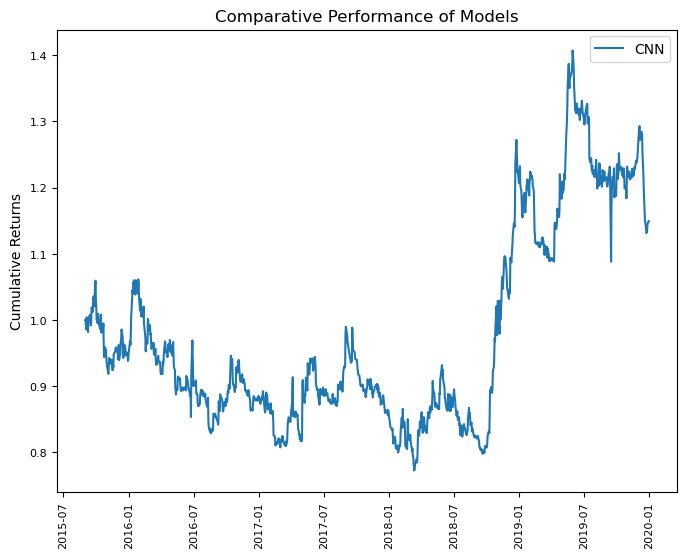

In [136]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], cnn_cumulative_returns, label = 'CNN')
#plt.plot(dates[-1092:], rf_cumulative_returns, label = 'Random Forest')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Comparative Performance of Models')
plt.legend()
plt.show()

### ARIMA

In [142]:
arima_returns = pd.read_csv("arima_manuprig.csv", delimiter=',')
arima_returns = arima_returns['arima_cim_prod']
arima_cumulative_returns = np.array(arima_returns)

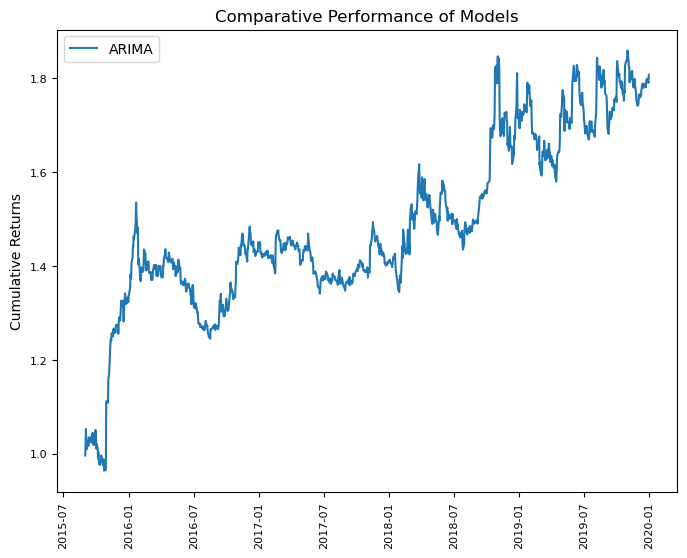

In [143]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], arima_cumulative_returns, label = 'ARIMA')
#plt.plot(dates[-1092:], rf_cumulative_returns, label = 'Random Forest')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Comparative Performance of Models')
plt.legend()
plt.show()

### LSTM

In [203]:
lstm_returns = pd.read_csv("lstm1.csv", delimiter=',')
lstm_returns = lstm_returns['lstm']
y_pred = np.array(lstm_returns)

In [174]:
weights = np.zeros((X_test_combined.shape[1], X_test_combined.shape[0]))
results = np.zeros(X_test_combined.shape[1])
for i in range(X_test_combined.shape[1]): 
    input_features = np.exp(X_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], X_test_combined.shape[2]))-1
    predicted_returns = np.exp(y_pred[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    actual_returns = np.exp(y_tst[list(range(0+i,X_tst.shape[0],X_test_combined.shape[1]))].reshape(X_test_combined.shape[0], 1))-1
    try:
        res = wrapper(input_features, predicted_returns, actual_returns, rates['daily'][i-1092])
        results[i] = res[0]
        weights[i] = res[1]
    except:
        weights[i] = weights[i-1]
        results[i] = returns(actual_returns, weights[i])

In [175]:
lstm_weights = weights
lstm_results = results
lstm_cumulative_returns = np.cumprod(lstm_results + 1)

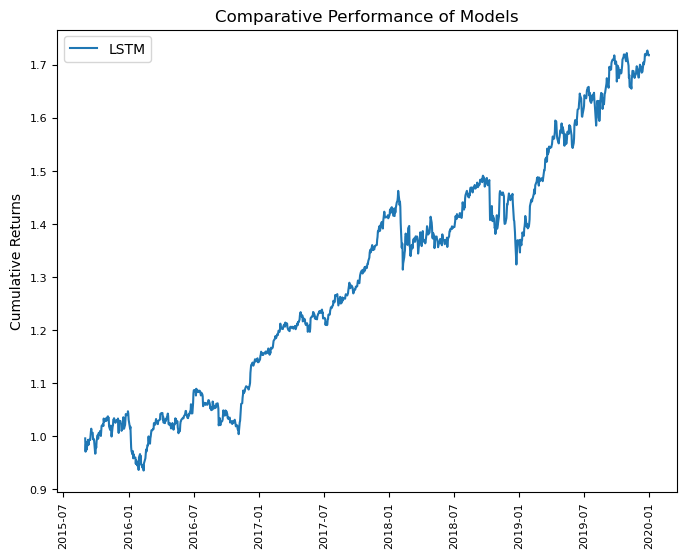

In [176]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], lstm_cumulative_returns, label = 'LSTM')
#plt.plot(dates[-1092:], rf_cumulative_returns, label = 'Random Forest')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Comparative Performance of Models')
plt.legend()
plt.show()

In [215]:
x = np.array(lstm_returns)
max(x)

0.0015455037

In [210]:
def error_metrics(y_tst, y_pred):
    errors = {}
    errors['MAE'] = mean_absolute_error(y_tst,y_pred) 
    errors['MSE'] = mean_squared_error(y_tst,y_pred) 
    errors['HR'] = np.sum(y_tst * y_pred > 0)/np.sum(y_tst * y_pred != 0)
    errors['HR+'] = np.sum(np.logical_and(y_tst > 0, y_pred > 0))/np.sum(y_pred > 0)
    print(np.sum(y_pred > 0))
    errors['HR-'] = np.sum(np.logical_and(y_tst < 0, y_pred < 0))/np.sum(y_pred < 0)
    return errors

In [211]:
error_metrics(y_tst,np.array(lstm_returns))

58968


/var/folders/f6/bv1ls9vn2zvc72swzbm89y800000gn/T/ipykernel_31757/2647180592.py:8: RuntimeWarning: invalid value encountered in long_scalars
  errors['HR-'] = np.sum(np.logical_and(y_tst < 0, y_pred < 0))/np.sum(y_pred < 0)


{'MAE': 0.010709821978541686,
 'MSE': 0.00025120211006379614,
 'HR': 0.5367498889989413,
 'HR+': 0.533017908017908,
 'HR-': nan}

### Comparative Plots - Results

In [164]:
temp = data[-1092:]
spdata = yf.download('^GSPC', start="2015-08-27", end="2019-12-31", interval="1d")

spdata = spdata['Adj Close']
spdata
spdata = spdata.pct_change()
spdata = spdata.dropna()
spdata = np.log(1+spdata)
spdata = spdata.dropna()

spdata = spdata.cumsum()
spdata = np.exp(spdata)

[*********************100%***********************]  1 of 1 completed


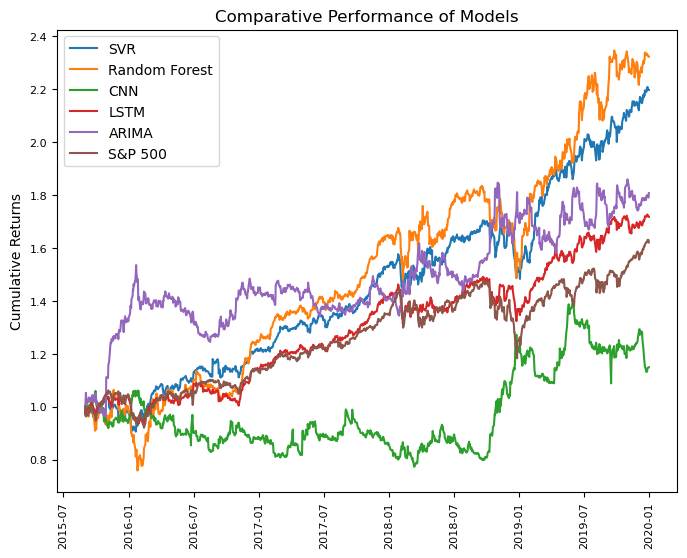

In [177]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], svr_cumulative_returns, label = 'SVR')
plt.plot(dates[-1092:], rf_cumulative_returns, label = 'Random Forest')
plt.plot(dates[-1092:], cnn_cumulative_returns, label = 'CNN')
plt.plot(dates[-1092:], lstm_cumulative_returns, label = 'LSTM')
plt.plot(dates[-1092:], arima_cumulative_returns, label = 'ARIMA')
plt.plot(dates[-1092:], spdata, label = 'S&P 500')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Comparative Performance of Models')
plt.legend()
plt.show()

### Yearly results

In [192]:
resultsdf = pd.DataFrame()
resultsdf['Date'] = dates[-1092:]
resultsdf['SVR'] = svr_results
resultsdf['RF'] = rf_results
resultsdf['CNN'] = cnn_results
resultsdf['LSTM'] = lstm_results

resultsdf['Month'] = resultsdf['Date'].astype(str).str[:7]
resultsdf['Month'] = resultsdf['Date'].astype(str).str[:7]
resultsdf['Month'] = pd.to_datetime(resultsdf['Month'])
resultsdf['Month'] = pd.to_datetime(resultsdf['Month']).dt.strftime('%Y-%m')
results2016 = resultsdf[(resultsdf['Date'] >= '2016-01-01') & (resultsdf['Date'] <= '2016-12-31')]
monthly_total = results2016.groupby('Month').sum()

monthly_total.index = pd.to_datetime(monthly_total.index)

,Date,SVR,RF,CNN,Month
86,2016-01-04,-0.015534,-0.015733,-0.018559,2016-01
87,2016-01-05,-0.001722,-0.012639,0.005947,2016-01
88,2016-01-06,-0.024641,-0.017759,-0.015163,2016-01
89,2016-01-07,-0.017302,-0.038288,-0.028226,2016-01
90,2016-01-08,-0.002621,0.000049,-0.007591,2016-01
...,...,...,...,...,...
333,2016-12-23,0.002234,0.008482,0.001680,2016-12
334,2016-12-27,0.002166,0.005111,0.001803,2016-12
335,2016-12-28,-0.007447,-0.006387,-0.007357,2016-12
336,2016-12-29,0.002374,0.003654,0.005994,2016-12


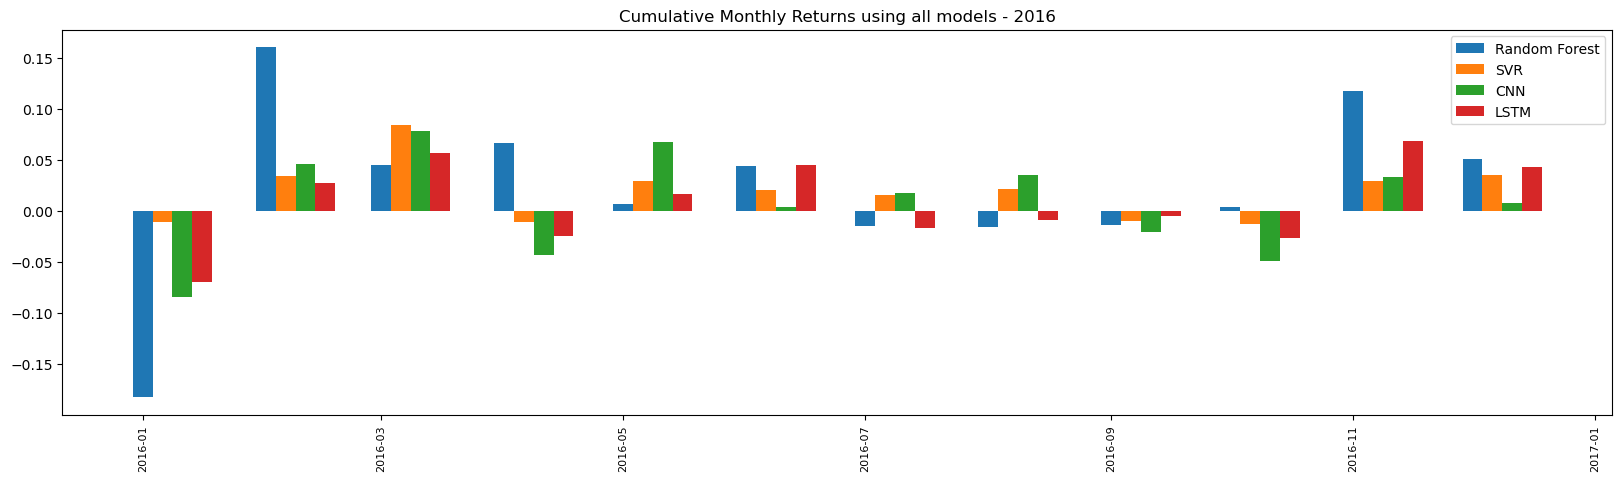

In [194]:
width = 5
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(monthly_total.index, monthly_total['RF'],width,label='Random Forest')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=5), monthly_total['SVR'],width, label='SVR')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=10), monthly_total['CNN'],width, label='CNN')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=15), monthly_total['LSTM'],width, label='LSTM')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.title('Cumulative Monthly Returns using all models - 2016')
plt.legend()
plt.show()

In [195]:
results2017 = resultsdf[(resultsdf['Date'] >= '2017-01-01') & (resultsdf['Date'] <= '2017-12-31')]
monthly_total = results2017.groupby('Month').sum()

monthly_total.index = pd.to_datetime(monthly_total.index)

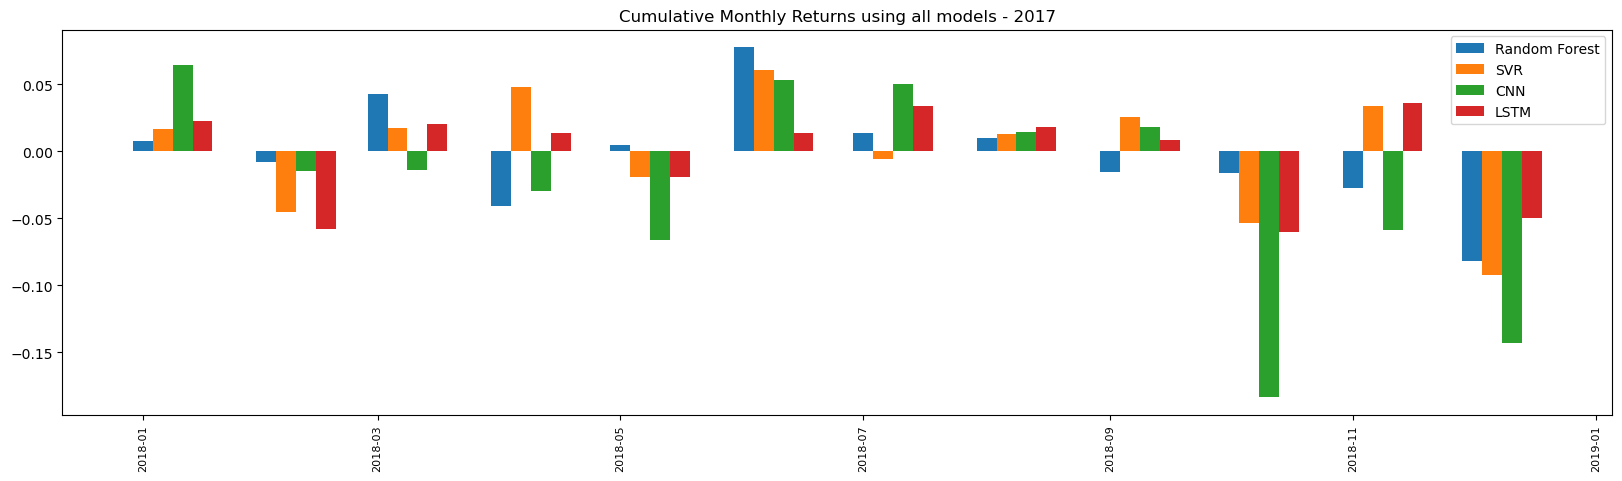

In [216]:
width = 5
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(monthly_total.index, monthly_total['RF'],width,label='Random Forest')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=5), monthly_total['SVR'],width, label='SVR')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=10), monthly_total['CNN'],width, label='CNN')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=15), monthly_total['LSTM'],width, label='LSTM')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.title('Cumulative Monthly Returns using all models - 2017')
plt.legend()
plt.show()

In [ ]:

# cols = dates[-1092:]
# df = pd.DataFrame(columns = cols)
# df.loc[len(df)] = np.array(results)
# df.loc[len(df)] = np.array(svr_results)

In [197]:
results2018 = resultsdf[(resultsdf['Date'] >= '2018-01-01') & (resultsdf['Date'] <= '2018-12-31')]
monthly_total = results2018.groupby('Month').sum()

monthly_total.index = pd.to_datetime(monthly_total.index)

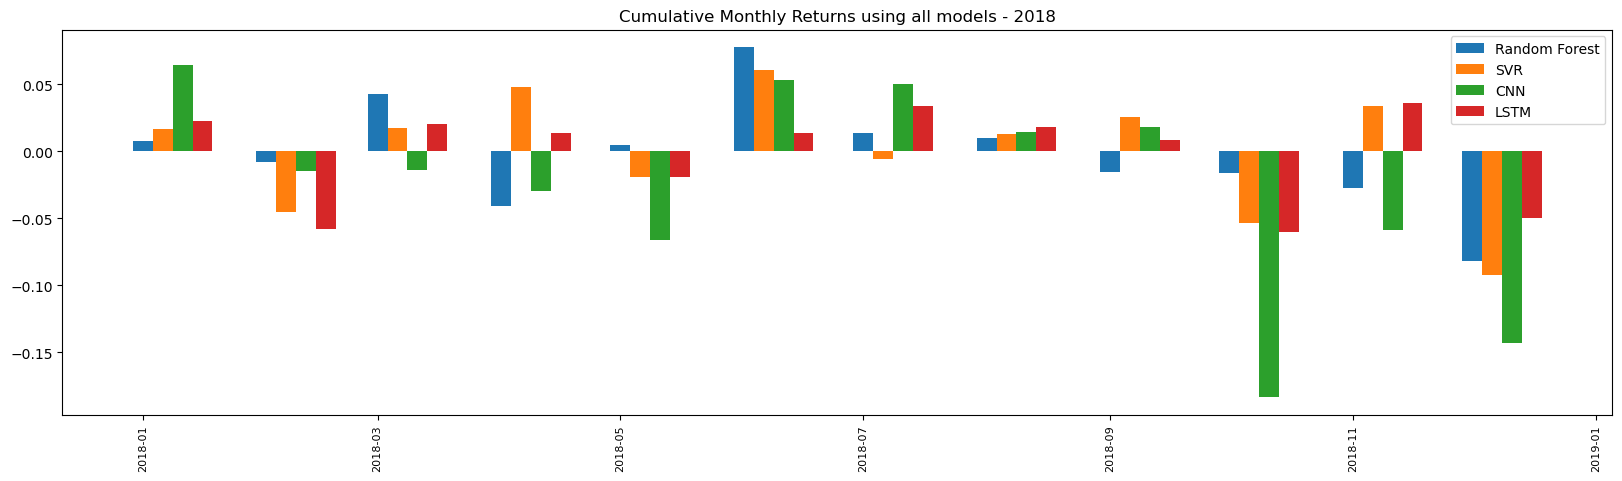

In [198]:
width = 5
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(monthly_total.index, monthly_total['RF'],width,label='Random Forest')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=5), monthly_total['SVR'],width, label='SVR')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=10), monthly_total['CNN'],width, label='CNN')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=15), monthly_total['LSTM'],width, label='LSTM')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.title('Cumulative Monthly Returns using all models - 2018')
plt.legend()
plt.show()

In [217]:
results2019 = resultsdf[(resultsdf['Date'] >= '2019-01-01') & (resultsdf['Date'] <= '2019-12-31')]
monthly_total = results2019.groupby('Month').sum()

monthly_total.index = pd.to_datetime(monthly_total.index)

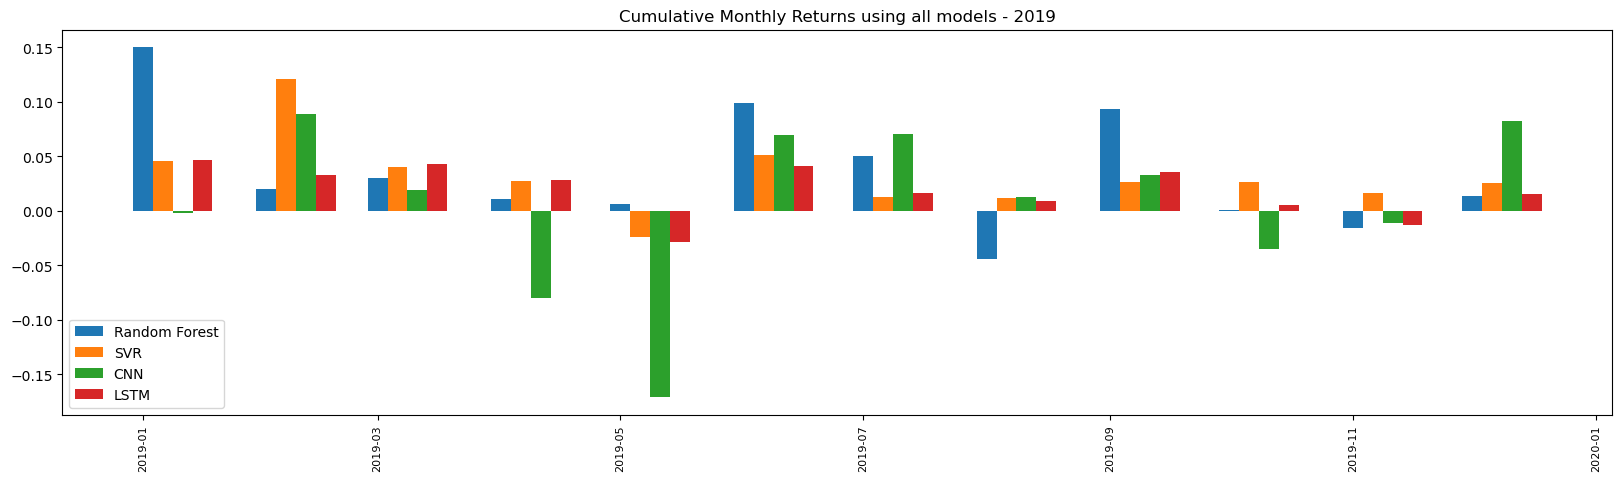

In [219]:
width = 5
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(monthly_total.index, monthly_total['RF'],width,label='Random Forest')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=5), monthly_total['SVR'],width, label='SVR')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=10), monthly_total['CNN'],width, label='CNN')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=15), monthly_total['LSTM'],width, label='LSTM')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.title('Cumulative Monthly Returns using all models - 2019')
plt.legend()
plt.show()

In [163]:
temp = data[-1092:]
spdata = yf.download('^GSPC', start="2015-08-27", end="2019-12-31", interval="1d")

spdata = spdata['Adj Close']
spdata
spdata = spdata.pct_change()
spdata = spdata.dropna()
spdata = np.log(1+spdata)
spdata = spdata.dropna()

spdata = spdata.cumsum()
spdata = np.exp(spdata)

In [ ]:
#df.plot()

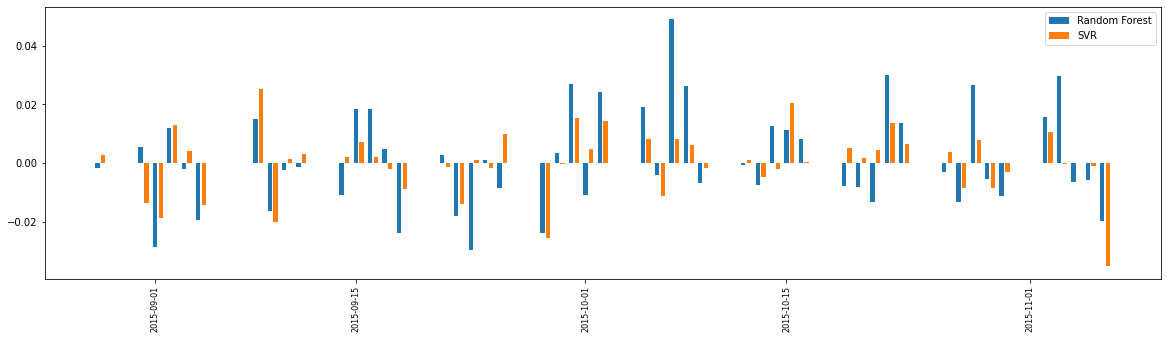

In [41]:
width = 0.3
#fig = plt.figure(figsize=(10,6))
fig, ax = plt.subplots(figsize=(20,5))
#rects1 = ax.bar(np.arange(X_test_combined.shape[1])[:200], results[0:200], width,label='Random Forest')
#rects2 = ax.bar(np.arange(X_test_combined.shape[1])[:200] + width, svr_results[0:200], width, label='SVR' )
rects1 = ax.bar(dates[-1092:][:50], rf_results[:50],width,label='Random Forest')
rects2 = ax.bar(dates[-1092:][:50] + pd.DateOffset(days=0.4), svr_results[:50],width, label='SVR')
#pd.DateOffset(days=180)
#plt.bar(dates[-1092:],[results, svr_results],label=['Random Forest', 'l2'])
#plt.bar(dates[-1092:],svr_results, label = 'SVR')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.legend()
plt.show()

In [42]:

#Year-wise Plots - creating the dataframe

resultsdf = pd.DataFrame()
resultsdf['Date'] = dates[-1092:]
resultsdf['SVR'] = svr_results
resultsdf['RF'] = rf_results


In [ ]:
resultsdf

,Date,SVR,RF
0,2015-08-28,0.002658,0.008673
1,2015-08-31,-0.013832,-0.007036
2,2015-09-01,-0.018769,-0.032417
3,2015-09-02,0.012936,0.018496
4,2015-09-03,0.003897,-0.006913
...,...,...,...
1087,2019-12-23,-0.001813,-0.003649
1088,2019-12-24,-0.001143,0.000573
1089,2019-12-26,0.007178,0.001543
1090,2019-12-27,0.001640,0.000052


In [ ]:
#Yearwise results

results2016 = resultsdf[(resultsdf['Date'] >= '2016-01-01') & (resultsdf['Date'] <= '2016-12-31')]

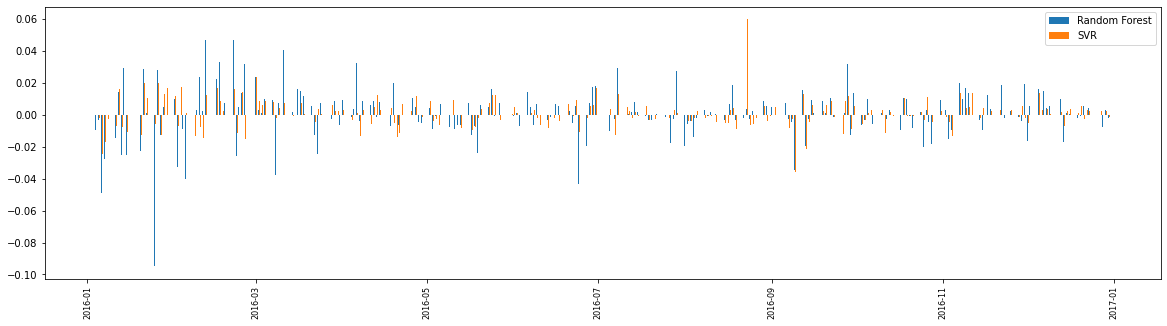

In [ ]:
width = 0.3
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(results2016['Date'], results2016['RF'],width,label='Random Forest')
rects2 = ax.bar(results2016['Date'] + pd.DateOffset(days=0.4), results2016['SVR'],width, label='SVR')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.legend()
plt.show()

In [ ]:
resultsdf['Month'] = resultsdf['Date'].astype(str).str[:7]
resultsdf

,Date,SVR,RF,Month
0,2015-08-28,0.002658,0.000228,2015-08
1,2015-08-31,-0.013832,0.006876,2015-08
2,2015-09-01,-0.018769,-0.035949,2015-09
3,2015-09-02,0.012936,0.018807,2015-09
4,2015-09-03,0.003897,0.000728,2015-09
...,...,...,...,...
1087,2019-12-23,-0.001813,-0.004455,2019-12
1088,2019-12-24,-0.001143,-0.000416,2019-12
1089,2019-12-26,0.007179,0.003219,2019-12
1090,2019-12-27,0.001639,-0.002216,2019-12


In [ ]:
resultsdf['Month'] = resultsdf['Date'].astype(str).str[:7]
resultsdf['Month'] = pd.to_datetime(resultsdf['Month'])
resultsdf['Month'] = pd.to_datetime(resultsdf['Month']).dt.strftime('%Y-%m')
#resultsdf['Month'] = pd.to_datetime(resultsdf['Month'])

monthly_total = resultsdf.groupby('Month').sum()
#.drop('Date', axis='columns')

In [ ]:
monthly_total.index = pd.to_datetime(monthly_total.index)

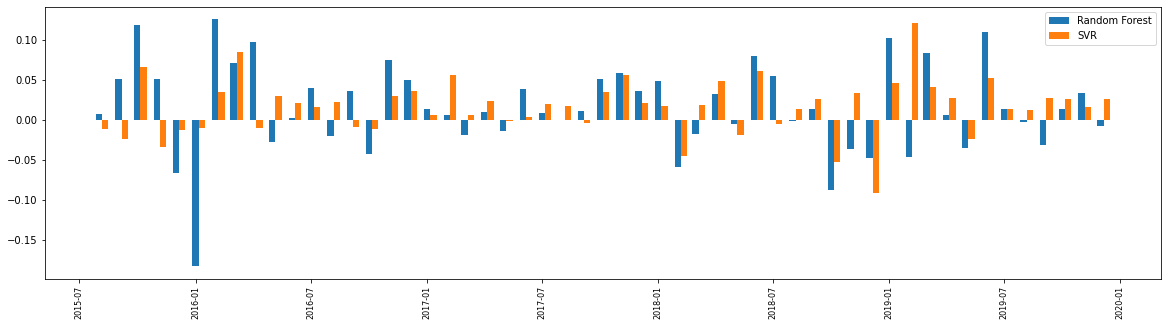

In [ ]:
width = 10
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(monthly_total.index, monthly_total['RF'],width,label='Random Forest')
rects2 = ax.bar(monthly_total.index + pd.DateOffset(days=10), monthly_total['SVR'],width, label='SVR')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.legend()
plt.show()

Get best and worst performing stocks to compare its weights across models

In [ ]:
logreturns = np.cumsum(data[-1092:],axis=0)
print(logreturns.shape)
logreturns = logreturns[-1:]
#logreturns
print(logreturns.shape)

(1092, 54)
(1, 54)


In [ ]:
bestidx = np.argmax(logreturns)
worstidx = np.argmin(logreturns)

In [ ]:
logreturns

,A,ABC,ABT,ADBE,ADI,ADM,ADP,AEE,AEP,AES,...,CVX,DIS,DVN,EA,EMN,EQR,GOOG,MMM,MO,T
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,0.883556,-0.11587,0.731017,1.425742,0.840538,0.161472,0.876114,0.766312,0.68593,0.688803,...,0.606503,0.406186,-0.411473,0.465096,0.197065,0.390682,0.739813,0.31592,0.135911,0.461472


In [ ]:
rf_best = rf_weights[:,bestidx]
rf_worst = rf_weights[:,worstidx]
svr_best = svr_weights[:,bestidx]
svr_worst = svr_weights[:,worstidx]

In [ ]:
svr_best.shape

(1092,)

In [ ]:
X_tst.shape

(58968, 60)

In [ ]:
bestreturns = data[-1092:][data.columns[bestidx]]
worstreturns = data[-1092:][data.columns[worstidx]]

bestreturns = np.exp(bestreturns) - 1
worstreturns = np.exp(worstreturns) - 1

In [ ]:
svr_best[ svr_best==0 ] = np.nan
svr_worst[ svr_worst==0 ] = np.nan

In [ ]:
np.count_nonzero(svr_best)

1092

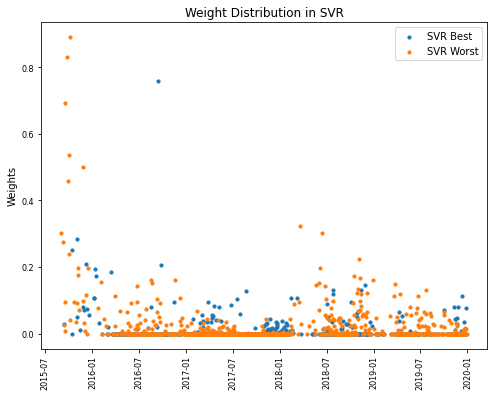

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.scatter(dates[-1092:], svr_best, label = 'SVR Best',s=10)
plt.scatter(dates[-1092:], svr_worst, label = 'SVR Worst',s=10)
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Weights')
plt.yticks(fontsize=8)
plt.title('Weight Distribution in SVR')
plt.legend()
plt.show()

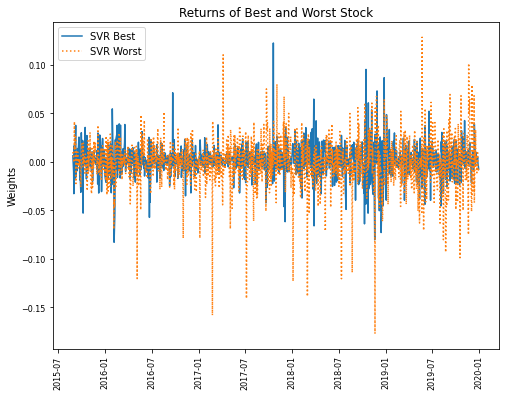

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], bestreturns, label = 'SVR Best')
plt.plot(dates[-1092:], worstreturns, label = 'SVR Worst',ls=':')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Weights')
plt.yticks(fontsize=8)
plt.title('Returns of Best and Worst Stock')
plt.legend()
plt.show()

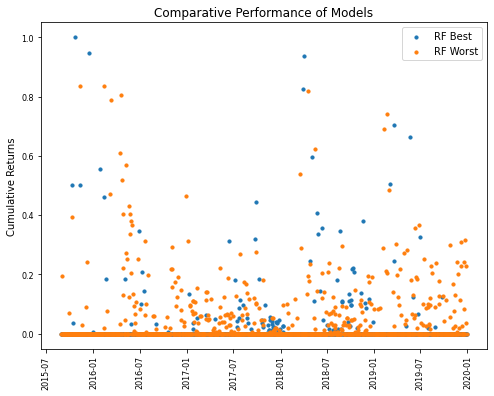

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.scatter(dates[-1092:], rf_best, label = 'RF Best',s=10)
plt.scatter(dates[-1092:], rf_worst, label = 'RF Worst',s=10)
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('Comparative Performance of Models')
plt.legend()
plt.show()

What if we only held S&P500 over that time?

In [43]:
temp = data[-1092:]
spdata = yf.download('^GSPC', start="2015-08-27", end="2019-12-31", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [44]:
spdata = spdata['Adj Close']

In [45]:
spdata
spdata = spdata.pct_change()
spdata = spdata.dropna()
spdata = np.log(1+spdata)
spdata = spdata.dropna()

In [46]:
spdata

Date
2015-08-28    0.000609
2015-08-31   -0.008427
2015-09-01   -0.030023
2015-09-02    0.018128
2015-09-03    0.001164
                ...   
2019-12-23    0.000866
2019-12-24   -0.000195
2019-12-26    0.005115
2019-12-27    0.000034
2019-12-30   -0.005798
Name: Adj Close, Length: 1092, dtype: float64

In [47]:
spdata = spdata.cumsum()
spdata = np.exp(spdata)

In [48]:
spdata

Date
2015-08-28    1.000609
2015-08-31    0.992212
2015-09-01    0.962866
2015-09-02    0.980480
2015-09-03    0.981622
                ...   
2019-12-23    1.622013
2019-12-24    1.621696
2019-12-26    1.630012
2019-12-27    1.630067
2019-12-30    1.620644
Name: Adj Close, Length: 1092, dtype: float64

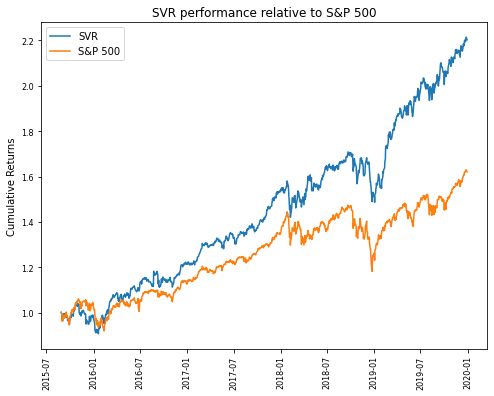

In [49]:
fig = plt.figure(figsize=(8,6))
plt.plot(dates[-1092:], svr_cumulative_returns, label = 'SVR')
plt.plot(dates[-1092:], spdata, label = 'S&P 500')
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns')
plt.yticks(fontsize=8)
plt.title('SVR performance relative to S&P 500')
plt.legend()
plt.show()

CNN Predictions

In [60]:
from numpy import loadtxt
cnn_returns = pd.read_csv("cnn_manuprig.csv", delimiter=',')

In [62]:
cnn_returns = cnn_returns['cnn_actual_ret']

In [64]:
cnn_returns.shape

(58968,)